In [1]:
import numpy as np
import matplotlib.pyplot as plt

from utils import datagen
from utils import datatreat
from utils import PCA
from utils import eigen_val
from utils import tau_GD
from utils import solve_ridge
from utils import GD

In [2]:
np.random.seed(1)

In [3]:
A_,y_ = datagen()
n,p,n_train,n_test,A,y,A_test,y_test = datatreat(A_,y_,0.6)

Number of obs: 173
n train: 103
n test: 70
Number of explicative variables: 9


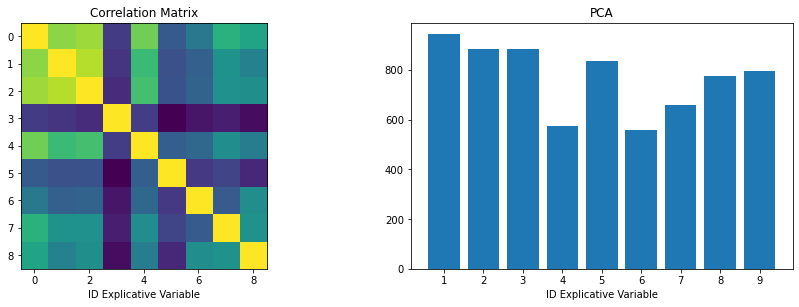

In [4]:
PCA(A,y)

In [5]:
Corr=np.corrcoef(A.T@A)
print(np.round(Corr,2))

[[ 1.    0.93  0.95 -0.43  0.88 -0.15  0.08  0.66  0.53]
 [ 0.93  1.    0.98 -0.34  0.82 -0.11 -0.04  0.51  0.35]
 [ 0.95  0.98  1.   -0.39  0.84 -0.11  0.    0.53  0.42]
 [-0.43 -0.34 -0.39  1.   -0.34 -0.45 -0.46 -0.47 -0.55]
 [ 0.88  0.82  0.84 -0.34  1.   -0.05 -0.01  0.48  0.31]
 [-0.15 -0.11 -0.11 -0.45 -0.05  1.   -0.23 -0.18 -0.36]
 [ 0.08 -0.04  0.   -0.46 -0.01 -0.23  1.    0.03  0.49]
 [ 0.66  0.51  0.53 -0.47  0.48 -0.18  0.03  1.    0.54]
 [ 0.53  0.35  0.42 -0.55  0.31 -0.36  0.49  0.54  1.  ]]


Eigen values: [0.08779221 0.10571643 0.29599832 0.34718336 0.52657565 0.80303564
 0.82495454 0.89759881 5.11114506]


mu = 0.08779220550281508
L = 5.111145062207626
mu/L = 0.017176621761718403


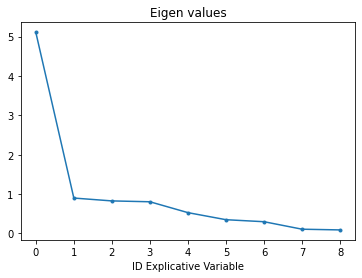

In [6]:
mu,L = eigen_val(A,show=1)

In [7]:
def mse(x,lbd): return 0.5*np.linalg.norm(A@x-y)**2/n_train+0.5*lbd*np.linalg.norm(x)**2

def dmse(x,lbd): return A.T@(A@x-y)/n_train+lbd*x

def mse_test(x): return np.linalg.norm(A_test@x-y_test)**2/n_test

In [8]:
lbd=0.1

tau_max,tau_opt=tau_GD(A,lbd)

tau_r=tau_max*10.**np.arange(0,-4,-1)
N_tau=tau_r.size

N_iter=10**2
x_0=np.zeros(p)

f = lambda x : mse(x,lbd)
df = lambda x : dmse(x,lbd)

In [9]:
x_ridge,fx_ridge=solve_ridge(A,y,lbd)

x_tau=np.zeros((N_tau,N_iter,p))
fx_tau=np.zeros((N_tau,N_iter))
err_x_tau=np.zeros((N_tau,N_iter))
err_fx_tau=np.zeros((N_tau,N_iter))

    
for i in range(N_tau):
    x_tau[i],fx_tau[i]=GD(tau_r[i],x_0,f,df,N_iter)
    err_x_tau[i]=np.linalg.norm(x_tau[i]-x_ridge,axis=1)
    err_fx_tau[i]=fx_tau[i]-fx_ridge

    
x_opti,fx_opti=GD(tau_opt,x_0,f,df,N_iter)
err_x_opti=np.linalg.norm(x_opti-x_ridge,axis=1)
err_fx_opti=fx_opti-fx_ridge

mu,L=eigen_val(A,lbd)
rho=(L-mu)/(L+mu)
cvg_rate=rho**np.arange(0,N_iter,1)

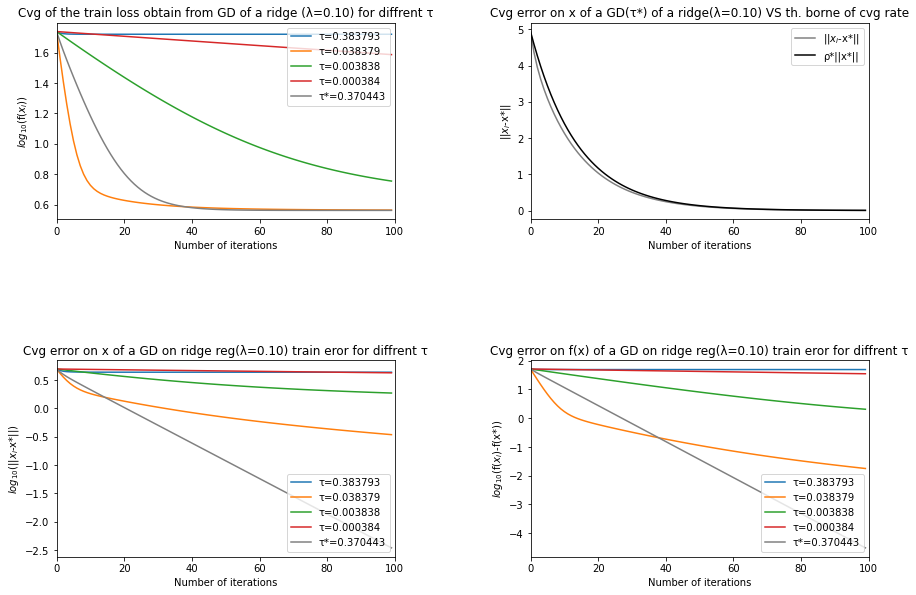

In [10]:
fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(nrows=2,ncols=2)

#-------------------------------------------------------------------------------------------------------
for i in range(N_tau): ax0.plot(np.log10(fx_tau[i]), label="τ=%f" % tau_r[i])
ax0.plot(np.log10(fx_opti), label="τ*=%f" % tau_opt,color='grey')


ax0.set_xlim(0,N_iter);
ax0.legend(loc="upper right")
ax0.set_xlabel("Number of iterations");
ax0.set_ylabel("$log_{10}$(f($x_i$))");
ax0.set_title("Cvg of the train loss obtain from GD of a ridge (λ=%.2f) for diffrent τ"%lbd)

#-------------------------------------------------------------------------------------------------------
ax1.plot(err_x_opti,color='grey',label="||$x_i$-x*||")
ax1.plot(cvg_rate*np.linalg.norm(x_ridge),color='black',label="ρ*||x*||")
ax1.set_xlim(0,N_iter);
ax1.legend()
ax1.set_xlabel("Number of iterations");
ax1.set_ylabel("||$x_i$-x*||");
ax1.set_title("Cvg error on x of a GD(τ*) of a ridge(λ=%.2f) VS th. borne of cvg rate"%lbd)
#-------------------------------------------------------------------------------------------------------
for i in range(N_tau): ax2.plot(np.log10(err_x_tau[i]), label="τ=%f" % tau_r[i])
ax2.plot(np.log10(err_x_opti), label="τ*=%f" % tau_opt,color='grey')


ax2.set_xlim(0,N_iter);
ax2.legend(loc="lower right")
ax2.set_xlabel("Number of iterations");
ax2.set_ylabel("$log_{10}$(||$x_i$-x*||)");
ax2.set_title("Cvg error on x of a GD on ridge reg(λ=%.2f) train eror for diffrent τ"%lbd)

#-------------------------------------------------------------------------------------------------------
for i in range(N_tau): ax3.plot(np.log10(err_fx_tau[i]), label="τ=%f" % tau_r[i])
ax3.plot(np.log10(err_fx_opti), label="τ*=%f" % tau_opt,color='grey')


ax3.set_xlim(0,N_iter);
ax3.legend(loc="lower right")
ax3.set_xlabel("Number of iterations");
ax3.set_ylabel("$log_{10}$(f($x_i$)-f(x*))");
ax3.set_title("Cvg error on f(x) of a GD on ridge reg(λ=%.2f) train eror for diffrent τ"%lbd)


fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=2, wspace=None, hspace=None)

In [11]:
LBD=10.**np.arange(-3,1,1)
N_lambda=LBD.size

N_iter=1*10**2
x_0=np.zeros(p)

tau_opt_ridge=np.zeros(N_lambda)
x_lbd=np.zeros((N_lambda,N_iter,p))
fx_lbd=np.zeros((N_lambda,N_iter))
fx_lbd_test=np.zeros((N_lambda,N_iter))
x_ridge_lbd=np.zeros((N_lambda,p))
fx_ridge_lbd=np.zeros(N_lambda)

for i in range(N_lambda):
    trash,tau_opt_ridge[i]=tau_GD(A,LBD[i])
    f = lambda x : mse(x,LBD[i])
    df = lambda x : dmse(x,LBD[i])
    x_lbd[i],fx_lbd[i]=GD(tau_opt_ridge[i],x_0,f,df,N_iter)
    x_ridge_lbd[i],fx_ridge_lbd[i]=solve_ridge(A,y,LBD[i])
    fx_lbd_test[i]=np.apply_along_axis(mse_test,axis=1,arr=x_lbd[i])

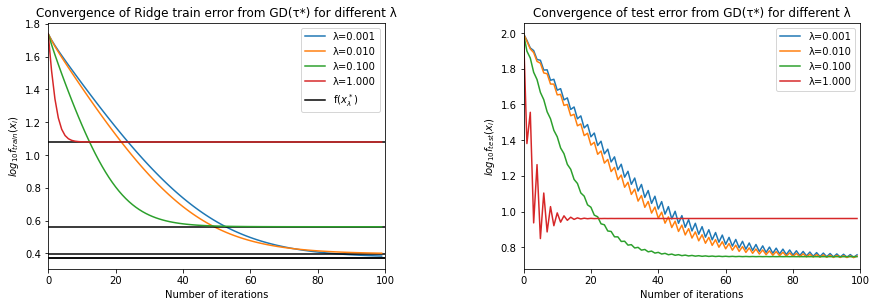

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)

#-------------------------------------------------------------------------------------------------------

for i in range(N_lambda):
    ax1.axhline(y = np.log10(fx_ridge_lbd[i]), color = 'black', linestyle = '-')
    ax1.plot(np.log10(fx_lbd[i,:]), label="λ=%.3f" % LBD[i])

ax1.axhline(y=np.log10(fx_ridge_lbd[0]),label='f($x_{\lambda}^*$)',color='black')
ax1.set_xlabel("Number of iterations");
ax1.set_ylabel("$log_{10}f_{train}(x_i$)");
ax1.legend(loc="upper right")
ax1.set_xlim(0,N_iter);
ax1.set_title("Convergence of Ridge train error from GD(τ*) for different λ")

#-------------------------------------------------------------------------------------------------------

for i in range(N_lambda): ax2.plot(np.log10(fx_lbd_test[i]), label="λ=%.3f" % LBD[i])    
ax2.set_xlabel("Number of iterations");
ax2.set_ylabel("$log_{10}f_{test}(x_i$)");
ax2.legend()
ax2.set_xlim(0,N_iter);
ax2.set_title("Convergence of test error from GD(τ*) for different λ")

#-------------------------------------------------------------------------------------------------------



fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(left=None, bottom=None, right=2, top=1, wspace=None, hspace=None)

λ*= 0.022857142857142857


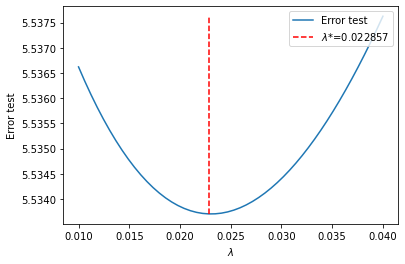

In [13]:
N_lbd=50
lambda_list = np.linspace(1e-2,4e-2,N_lbd)


x_ridge_lambda = np.zeros((N_lbd,p))
error_test_lambda = np.zeros(N_lbd)

for i in np.arange(0,N_lbd):
    Lambda = lambda_list[i]
    x_ridge_lambda[i],trash = solve_ridge(A,y,Lambda)
    error_test_lambda[i] = mse_test(x_ridge_lambda[i])
    
i_opti = error_test_lambda.argmin()
lambda_opti = lambda_list[i_opti]

plt.plot(lambda_list, error_test_lambda,label="Error test")
plt.plot( [lambda_opti,lambda_opti], [error_test_lambda.min(), error_test_lambda.max()], 'r--',label="$\lambda$*=%f"%lambda_opti)
plt.xlabel('$\lambda$');
plt.ylabel('Error test');
plt.legend(loc="upper right");
print("λ*=",lambda_opti)